# DDPG algorithm in flax

In [1]:
import gymnasium as gym
import numpy as np
from collections import deque
import optax
import matplotlib.pyplot as plt
import time

import jax.tree_util as jtu
from jax import random
import jax.numpy as jnp
import jax

from flax.training import train_state, orbax_utils
from flax import linen as nn  # Linen API

from tqdm import tqdm
import orbax.checkpoint
import os
import shutil

F_CPP_MIN_LOG_LEVEL=0

In [1]:
ckpt_dir = './agent' # create the agent folder

## Usefull Methods

In [3]:
#random process N for action exploration
@jtu.Partial(jax.jit, static_argnums=2)
def noise(noise_scale=0.1, key=random.PRNGKey(0), action_dim=2):
    return noise_scale * jax.random.normal(key, (action_dim,))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
# Define the method to update model parameters

# update critic
@jax.jit
def update_critic(model, states, actions, y):
    def compute_critic_loss(params):
        Q = model.apply_fn(params, states, actions)
        
        return jnp.mean((Q - y)**2) #compute loss
    
    loss, grads = jax.value_and_grad(compute_critic_loss)(model.params)
    updated_model = model.apply_gradients(grads=grads)
   
    return updated_model, loss

# udate actor
@jtu.Partial(jax.jit, static_argnums=(2,))
def update_actor(model, states, action_dim):
    def compute_actor_loss(params):
        actions = model.apply_fn(params, states, action_dim)

        return -jnp.mean(actions)  # Compute the actor loss

    loss, grads = jax.value_and_grad(compute_actor_loss)(model.params)
    updated_model = model.apply_gradients(grads=grads)

    return updated_model, loss

# Define the soft update function
@jax.jit
def soft_update(target_params, source_params, tau):
    # Convert the source_params to a JAX-compatible data structure
    source_params_tree = jtu.tree_map(lambda x: jnp.asarray(x), source_params)
    target_params_tree = jtu.tree_map(lambda x: jnp.asarray(x), target_params)

    # Compute the updated target parameters using a soft update
    updated_params = jtu.tree_map(lambda x, y: tau * x + (1 - tau) * y,
                                  source_params_tree, target_params_tree)

    return updated_params

## Define ReplayBuffer

In [5]:
# define the replay buffer
class ReplayBuffer():
    def __init__(self, buffer_size, batch_size, key):
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.buffer = deque(maxlen=self.buffer_size)
        self.key = key

    def add(self, transition):
        self.buffer.append(transition)

    def sample_batch(self):
        indices = jax.random.choice(self.key, len(self.buffer),
                                    shape=(self.batch_size,), replace=True)
        batch = [self.buffer[i] for i in indices]

        return zip(*batch)

## Define actor and critic model

In [6]:
#create the actor and critic newtorks like multilayer perceptrons
class Critic(nn.Module):
    """critic model MLP"""
    
    @nn.compact
    def __call__(self, observations, actions):
        x = jnp.concatenate([observations, actions], axis=-1)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=1)(x)
        return jnp.squeeze(x, axis=-1)
    
class Actor(nn.Module):
    """actor model MLP"""
    
    @nn.compact
    def __call__(self, x, action_dim):
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=action_dim)(x)
        x = nn.tanh(x)
        return x

## Define algorithm parameters

In [54]:
# define environment and parameters
env = gym.make("InvertedPendulum-v4")
action_dim = env.action_space.shape[0]
state_dim = env.observation_space.shape[0]

#initialize parameters
seed = 0
key = random.PRNGKey(seed)
episodes = 50
gamma = 0.99 #discount factor 0:nearly rewards, 1:future rewards
tau = 0.995 #polyak between 0-1 updating target network
max_episode_steps = 1000
buffer_size = 1000000 #memory size
batch_size = 100 #The number of experiences sampled from the replay buffer
learning_rate = 0.001
noise_scale = 0.1 #scale of the noise for random process N for action exploration
start_steps = 1000 # Number of steps for uniform-random action selection,before running real policy. Helps exploration.

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=max_episode_steps)

if os.path.exists(ckpt_dir):
    shutil.rmtree(ckpt_dir)

## Initialize models and buffer

In [55]:
# Randomly initialize critic network Q(s, a|θ_Q ) and actor μ(s|θ_μ ) with weights θ_Q and θ_μ .
critic_params = Critic().init(key,
                              jnp.zeros((1, state_dim)),
                              jnp.zeros((1, action_dim)))

actor_params = Actor().init(key, jnp.zeros((1, state_dim)), action_dim)

# define optimizers
actor_optimizer = optax.adam(learning_rate=learning_rate)
actor_opt_state = actor_optimizer.init(actor_params)

critic_optimizer = optax.adam(learning_rate=learning_rate)
critic_opt_state = critic_optimizer.init(critic_params)

# Initialize the training state for flax porpuses
critic = train_state.TrainState.create(
    apply_fn=Critic().apply,
    params=critic_params,
    tx=critic_optimizer
)

actor = train_state.TrainState.create(
    apply_fn=Actor().apply,
    params=actor_params,
    tx=actor_optimizer,
)

# to save agent
config = {'dimensions': jnp.array([5,3]), 'name': 'actor'}
ckpt = {'model': actor, 'config': config, 'data': actor_params}

# print(Actor().tabulate(key, (1, state_dim), action_dim))
# print(Critic().tabulate(key, jnp.ones((1,action_dim)), jnp.ones((1,state_dim))))

In [56]:
# Initialize target network Q_0_target and μ_0_target with weights 
# θ_Q_target ← θ_Q , θ_μ_target ← θ_μ

target_critic_params = critic_params
target_actor_params = actor_params

# Initialize the training state for flax porpuses
target_critic = train_state.TrainState.create(
    apply_fn=Critic().apply,
    params=target_critic_params,
    tx=critic_optimizer
)

target_actor = train_state.TrainState.create(
    apply_fn=Actor().apply,
    params=target_actor_params,
    tx=actor_optimizer
)

In [57]:
# Initialize replay buffer R
buffer = ReplayBuffer(buffer_size, batch_size, key)

## Training

In [60]:
episodes_reward = []
critic_loss = 0
actor_loss = 0
start_time = time.time()

for i in tqdm(range(episodes)):
    # Initialize a random process N for action exploration
    N = noise(noise_scale, key, action_dim)
    # Receive initial observation state s 1
    state, info = env.reset(seed=seed)
    done = False
    t = 1

    while not done:
        # Select action a_t = μ(s t |θ μ ) + N t according to the current policy and exploration noise
        if t > start_steps:
            action = actor.apply_fn(actor.params, state, action_dim) + N
        else:
            action = env.action_space.sample()

        # Execute action a t and observe reward r t and observe new state s t+1
        observation, reward, terminated, truncated, info = env.step(action)
        
        # Store transition (s t , a t , r t , s t+1 ) in R
        transition = (state, action, reward, observation)
        buffer.add(transition)
            
        # Sample a random minibatch of N transitions (s i , a i , r i , s i+1 ) from R
        states, actions, rewards, next_states = buffer.sample_batch()

        # Set y = r  + γQ^0 (s_{i+1} , μ^0 (s_{i+1} |θ^μ )|θ^Q ) P
        target_action = target_actor.apply_fn(target_actor_params,
                                              jnp.asarray(next_states),
                                              action_dim)

        target_q = target_critic.apply_fn(target_critic_params,
                                          jnp.asarray(next_states),
                                          jnp.asarray(target_action))

        y = reward + gamma * (1 - terminated) * target_q

        # Update critic by minimizing the loss
        critic, critic_loss = update_critic(critic,
                                            jnp.asarray(states),
                                            jnp.asarray(actions),
                                            jnp.asarray(y))

        # Update the actor policy using the sampled gradient:
        actor, actor_loss = update_actor(actor,
                                         jnp.asarray(states),
                                         action_dim)

        # Update the target networks:
        target_actor_params = soft_update(target_actor_params, actor.params, tau)
        target_critic_params = soft_update(target_critic_params, critic.params, tau)
       
        # update if the environment is done and the current observation
        t += 1
        done = terminated or truncated

    episodes_reward.append(env.return_queue[-1]) 
    avg_reward = int(np.mean(env.return_queue))
    
    print("Episode:", i+1, "\n")
    # print("reward:", env.return_queue[-1])
    print("Average reward:", avg_reward)
    print("Critic loss:", critic_loss)
    print("Actor loss:", actor_loss)

env.close()

# save agent
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(ckpt)
orbax_checkpointer.save('./agent', ckpt, save_args=save_args)

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time)

  2%|███▏                                                                                                                                                           | 1/50 [00:01<01:19,  1.62s/it]

Episode: 1 

Average reward: 5
Critic loss: 9.177793
Actor loss: -0.12141443


  4%|██████▎                                                                                                                                                        | 2/50 [00:01<00:38,  1.26it/s]

Episode: 2 

Average reward: 5
Critic loss: 8.19771
Actor loss: -0.17963336


  6%|█████████▌                                                                                                                                                     | 3/50 [00:02<00:25,  1.82it/s]

Episode: 3 

Average reward: 5
Critic loss: 7.29376
Actor loss: -0.2776875


  8%|████████████▋                                                                                                                                                  | 4/50 [00:02<00:19,  2.33it/s]

Episode: 4 

Average reward: 5
Critic loss: 8.696298
Actor loss: -0.39980024


 10%|███████████████▉                                                                                                                                               | 5/50 [00:03<00:28,  1.59it/s]

Episode: 5 

Average reward: 5
Critic loss: 83.34178
Actor loss: -0.9054367


 12%|███████████████████                                                                                                                                            | 6/50 [00:03<00:23,  1.85it/s]

Episode: 6 

Average reward: 5
Critic loss: 106.578476
Actor loss: -0.9630049


 16%|█████████████████████████▍                                                                                                                                     | 8/50 [00:04<00:16,  2.61it/s]

Episode: 7 

Average reward: 5
Critic loss: 98.97372
Actor loss: -0.98186064
Episode: 8 

Average reward: 5
Critic loss: 81.604805
Actor loss: -0.9874687


 18%|████████████████████████████▌                                                                                                                                  | 9/50 [00:04<00:13,  3.11it/s]

Episode: 9 

Average reward: 5
Critic loss: 78.724014
Actor loss: -0.99092156


 22%|██████████████████████████████████▊                                                                                                                           | 11/50 [00:04<00:10,  3.56it/s]

Episode: 10 

Average reward: 5
Critic loss: 54.6701
Actor loss: -0.9941391
Episode: 11 

Average reward: 5
Critic loss: 51.56526
Actor loss: -0.9952504


 24%|█████████████████████████████████████▉                                                                                                                        | 12/50 [00:05<00:09,  3.88it/s]

Episode: 12 

Average reward: 5
Critic loss: 45.51786
Actor loss: -0.99602336


 26%|█████████████████████████████████████████                                                                                                                     | 13/50 [00:06<00:17,  2.15it/s]

Episode: 13 

Average reward: 5
Critic loss: 105.60348
Actor loss: -0.99779433


 28%|████████████████████████████████████████████▏                                                                                                                 | 14/50 [00:06<00:19,  1.83it/s]

Episode: 14 

Average reward: 5
Critic loss: 240.44995
Actor loss: -0.9982714


 32%|██████████████████████████████████████████████████▌                                                                                                           | 16/50 [00:07<00:12,  2.68it/s]

Episode: 15 

Average reward: 5
Critic loss: 284.71014
Actor loss: -0.99838024
Episode: 16 

Average reward: 5
Critic loss: 337.14655
Actor loss: -0.9984524


 34%|█████████████████████████████████████████████████████▋                                                                                                        | 17/50 [00:07<00:12,  2.61it/s]

Episode: 17 

Average reward: 5
Critic loss: 314.5257
Actor loss: -0.9985974


 36%|████████████████████████████████████████████████████████▉                                                                                                     | 18/50 [00:07<00:10,  2.92it/s]

Episode: 18 

Average reward: 5
Critic loss: 350.5653
Actor loss: -0.9986691


 38%|████████████████████████████████████████████████████████████                                                                                                  | 19/50 [00:08<00:10,  2.87it/s]

Episode: 19 

Average reward: 5
Critic loss: 370.47546
Actor loss: -0.9987655


 40%|███████████████████████████████████████████████████████████████▏                                                                                              | 20/50 [00:08<00:09,  3.16it/s]

Episode: 20 

Average reward: 5
Critic loss: 371.46796
Actor loss: -0.9988238


 42%|██████████████████████████████████████████████████████████████████▎                                                                                           | 21/50 [00:08<00:08,  3.40it/s]

Episode: 21 

Average reward: 5
Critic loss: 411.54468
Actor loss: -0.99887764


 46%|████████████████████████████████████████████████████████████████████████▋                                                                                     | 23/50 [00:09<00:08,  3.23it/s]

Episode: 22 

Average reward: 5
Critic loss: 539.3708
Actor loss: -0.9989865
Episode: 23 

Average reward: 5
Critic loss: 620.0773
Actor loss: -0.99901915


 50%|███████████████████████████████████████████████████████████████████████████████                                                                               | 25/50 [00:10<00:08,  2.80it/s]

Episode: 24 

Average reward: 5
Critic loss: 988.91016
Actor loss: -0.9991363
Episode: 25 

Average reward: 5
Critic loss: 992.75073
Actor loss: -0.9991627


 52%|██████████████████████████████████████████████████████████████████████████████████▏                                                                           | 26/50 [00:10<00:08,  2.70it/s]

Episode: 26 

Average reward: 5
Critic loss: 1395.5857
Actor loss: -0.99921966


 54%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 27/50 [00:11<00:08,  2.78it/s]

Episode: 27 

Average reward: 5
Critic loss: 1507.4506
Actor loss: -0.999257


 58%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 29/50 [00:11<00:07,  2.94it/s]

Episode: 28 

Average reward: 5
Critic loss: 1939.454
Actor loss: -0.99931836
Episode: 29 

Average reward: 5
Critic loss: 2486.392
Actor loss: -0.9993371


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 31/50 [00:12<00:07,  2.53it/s]

Episode: 30 

Average reward: 5
Critic loss: 4785.2837
Actor loss: -0.99941623
Episode: 31 

Average reward: 5
Critic loss: 6065.215
Actor loss: -0.99943143


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 32/50 [00:13<00:09,  1.94it/s]

Episode: 32 

Average reward: 5
Critic loss: 9370.2
Actor loss: -0.9995038


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 33/50 [00:13<00:07,  2.13it/s]

Episode: 33 

Average reward: 5
Critic loss: 11362.417
Actor loss: -0.9995409


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 34/50 [00:14<00:07,  2.27it/s]

Episode: 34 

Average reward: 5
Critic loss: 12757.797
Actor loss: -0.99957854


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 35/50 [00:15<00:08,  1.71it/s]

Episode: 35 

Average reward: 6
Critic loss: 21894.355
Actor loss: -0.9996742


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 36/50 [00:15<00:07,  1.97it/s]

Episode: 36 

Average reward: 6
Critic loss: 24343.477
Actor loss: -0.99970084


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 38/50 [00:16<00:04,  2.42it/s]

Episode: 37 

Average reward: 6
Critic loss: 39699.625
Actor loss: -0.9997441
Episode: 38 

Average reward: 6
Critic loss: 37366.6
Actor loss: -0.99975705


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 39/50 [00:16<00:03,  2.88it/s]

Episode: 39 

Average reward: 6
Critic loss: 40215.93
Actor loss: -0.9997694


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 40/50 [00:16<00:03,  3.01it/s]

Episode: 40 

Average reward: 5
Critic loss: 40327.535
Actor loss: -0.99978846


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 41/50 [00:16<00:02,  3.28it/s]

Episode: 41 

Average reward: 5
Critic loss: 35982.453
Actor loss: -0.99980223


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 42/50 [00:17<00:02,  3.41it/s]

Episode: 42 

Average reward: 5
Critic loss: 38987.367
Actor loss: -0.9998151


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 44/50 [00:17<00:01,  3.84it/s]

Episode: 43 

Average reward: 5
Critic loss: 36864.664
Actor loss: -0.9998297
Episode: 44 

Average reward: 5
Critic loss: 28860.654
Actor loss: -0.9998379


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 45/50 [00:18<00:01,  3.56it/s]

Episode: 45 

Average reward: 5
Critic loss: 35432.84
Actor loss: -0.9998503


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 46/50 [00:18<00:01,  3.11it/s]

Episode: 46 

Average reward: 5
Critic loss: 35176.242
Actor loss: -0.99986565


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 47/50 [00:18<00:00,  3.34it/s]

Episode: 47 

Average reward: 5
Critic loss: 35910.92
Actor loss: -0.99987334


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 48/50 [00:19<00:00,  3.33it/s]

Episode: 48 

Average reward: 5
Critic loss: 43724.688
Actor loss: -0.9998823


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 49/50 [00:19<00:00,  2.59it/s]

Episode: 49 

Average reward: 5
Critic loss: 45490.234
Actor loss: -0.99989784


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:19<00:00,  2.52it/s]

Episode: 50 

Average reward: 5
Critic loss: 46425.008
Actor loss: -0.999903


ValueError: Destination agent already exists.

## Visualizing the training

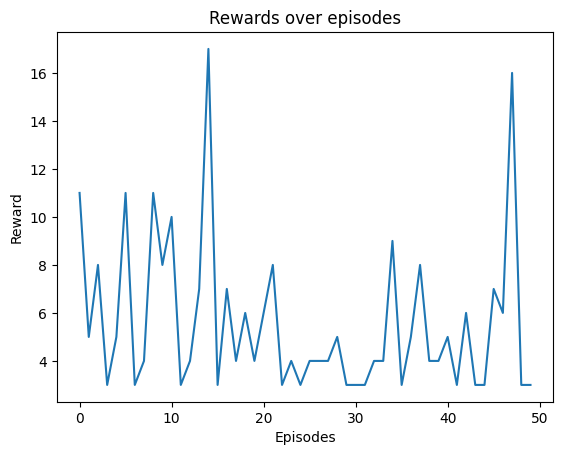

In [59]:
rewards_to_plot = [rewards for rewards in episodes_reward]

plt.plot(range(episodes), episodes_reward)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Rewards over episodes')
plt.show()

## Test Agent

In [51]:
# restore agent
raw_restored = orbax_checkpointer.restore('./agent')
actor_params = raw_restored['data']

In [52]:
env = gym.make("InvertedPendulum-v4", render_mode="human")

observation, info = env.reset()

for _ in range(1000):
    action = actor.apply_fn(actor_params, observation, env.action_space.shape[0])
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()

env.close()